In [ ]:
import json
import math
import os
import cv2
from PIL.Image import open
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from tqdm import tqdm
from collections import Counter
import json
import itertools
from imutils import paths
import cv2
from glob import glob
import random
import fnmatch


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix as matt

In [ ]:
import keras
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten,\
                         Conv2D, MaxPooling2D, GlobalAveragePooling2D, RepeatVector, LSTM, Dropout,TimeDistributed,MaxPool2D

# Additional Convolutional layers ( Use only if requirex in the future)
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D,Input, SeparableConv2D
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional

# Optimizers 
from tensorflow.keras.optimizers import Adam as adam



In [ ]:
from IPython.display import Image

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D as ConvLSTM2D

In [ ]:
# Mount the input dataset from google drive 
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!ls /content/gdrive/MyDrive/final_project

8913.zip	    idc_dataset_11.zip	IDC_new_final.zip
final.zip	    idc_dataset_12.zip	IDC_new.zip
IDC_comp.zip	    idc_dataset_13.zip	IDC_regular_ps50_idx5_6.zip
idc_dataset_10.zip  IDC_final.zip	IDC_regular_ps50_idx5.zip


In [ ]:
!unzip -uq "/content/gdrive/MyDrive/final_project/idc_dataset_13.zip"


warning [/content/gdrive/MyDrive/final_project/idc_dataset_13.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/gdrive/MyDrive/final_project/idc_dataset_13.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #69063).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


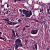

In [ ]:
# Image sample from dataset
from IPython.display import Image as Image

img = Image("IDC_regular_ps50_idx5/8864/1/8864_idx5_x1701_y2301_class1.png")
img

In [ ]:
img_name = glob('idc_dataset_13/**/*.png', recursive=True)
print("Total number of images:", len(img_name))
print("\nSample image names: ", *random.sample(img_name, 5), sep='\n')

Total number of images: 68836

Sample image names: 
idc_dataset_13/10272/0/10272_idx5_x3851_y701_class0.png
idc_dataset_13/10306/0/10306_idx5_x1101_y1801_class0.png
idc_dataset_13/9041/1/9041_idx5_x2151_y1201_class1.png
idc_dataset_13/10299/1/10299_idx5_x2151_y901_class1.png
idc_dataset_13/10303/1/10303_idx5_x1551_y901_class1.png


In [ ]:
# Classifying negative and positive idc images
negative_idc = fnmatch.filter(img_name, '*class0.png')
positive_idc = fnmatch.filter(img_name, '*class1.png')

print(negative_idc[3])
print(positive_idc[3])

idc_dataset_13/10306/0/10306_idx5_x1651_y901_class0.png
idc_dataset_13/10306/1/10306_idx5_x651_y801_class1.png


In [ ]:
import PIL.Image
dimensions = []
max_width = 0; max_height = 0; 
for imgs in tqdm(img_name):
    new_image = PIL.Image.open(imgs)
    dim = new_image.size
    if dim not in dimensions:
        dimensions.append(dim)
        if max_width < dim[0]:
            max_width = dim[0]
        if max_height < dim[1]:
            max_height = dim[1]       
        
print("\nDifferent image patch dimensions :", dimensions)
print("\nThe total number of different image patch dimensions :", len(dimensions))
print("max_width :", max_width, "  max_height :", max_height, "\n")

100%|██████████| 68836/68836 [00:06<00:00, 10522.46it/s]



Different image patch dimensions : [(50, 50), (50, 6), (26, 50), (26, 6), (50, 36), (22, 50), (50, 20), (32, 50), (31, 50), (12, 50), (50, 33), (50, 37), (50, 3), (50, 35), (50, 45), (50, 30), (50, 8), (50, 47), (42, 50), (50, 1), (50, 42), (32, 42), (50, 49), (50, 19), (50, 34), (50, 31), (50, 14), (11, 50)]

The total number of different image patch dimensions : 28
max_width : 50   max_height : 50 



In [ ]:
# Now I will convert the images into a list and then
# to a pandas DataFrame because they are easy to work with.
images = []
labels = []
width = 50; height = 50

total_images_to_process = int(len(img_name)) 
selected_images = np.random.choice(img_name, size=total_images_to_process)

for img in tqdm(selected_images):
    image = cv2.imread(img)
    # resize all images to size 50*50
    images.append(cv2.resize(image, (width, height),\
                             interpolation=cv2.INTER_CUBIC))
    if img in negative_idc:
        labels.append(0)
    if img in positive_idc:
        labels.append(1)
        
    X, Y =  images, labels



100%|██████████| 68836/68836 [01:23<00:00, 822.35it/s]


In [ ]:
    
# Assign the arrays to a pandas dataframe

temp_df = pd.DataFrame({"Images" : X, "Labels" : Y}) 
print("Total image patches taken for playing :", total_images_to_process)
#print(temp_df.describe())
#print(temp_df["Labels"].value_counts())

Total image patches taken for playing : 68836


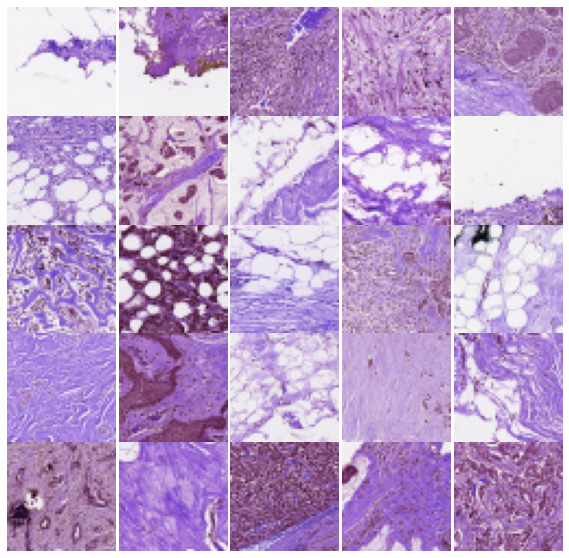

In [ ]:
# plot a few random images
def plot_imgs(img):
    random_index = np.random.randint(temp_df["Images"].shape[0], size=25)
    bunch_of_images = temp_df["Images"].iloc[random_index]
    #bunch_of_images = random.sample(X, 25)
    count = 0
    #plt.clf()
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.subplots_adjust(wspace=0, hspace=0)

    for image in bunch_of_images:
        plt.subplot(5, 5, count+1)
        plt.imshow(image)
        plt.axis('off')
        count += 1
    plt.show()

plot_imgs(temp_df["Images"])
#print(temp_df["Images"].shape)

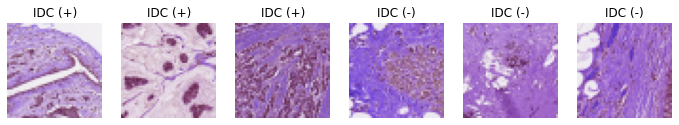

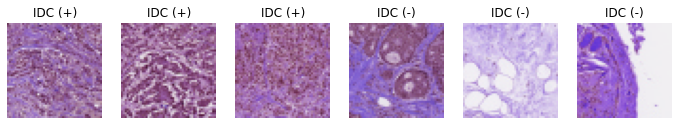

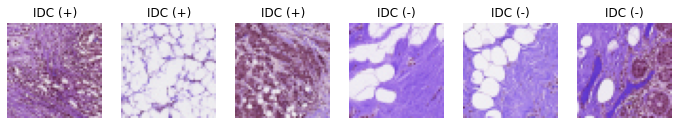

In [ ]:
# Sample the positive and negative into different variables
positive_images = temp_df["Images"].loc[temp_df["Labels"] == 1]
negative_images = temp_df["Images"].loc[temp_df["Labels"] == 0]

# to print random positive and negative images
index = np.random.randint(positive_images.shape[0])

sample_positive_images = positive_images.iloc[index:index+9]
sample_negative_images = negative_images.iloc[index:index+9]

count = 0
for row in range(3):
    plt.figure(figsize=(16, 8))
    for col in range(3):
        plt.subplot(1,8,col+1)
        plt.title('IDC (+)')
        plt.imshow(sample_positive_images.iloc[count])
        #print(col+1)
        plt.axis('off')       
        plt.subplot(1,8,col+4)
        plt.title('IDC (-)')
        plt.imshow(sample_negative_images.iloc[count])
        plt.axis('off')
        count += 1
plt.show()

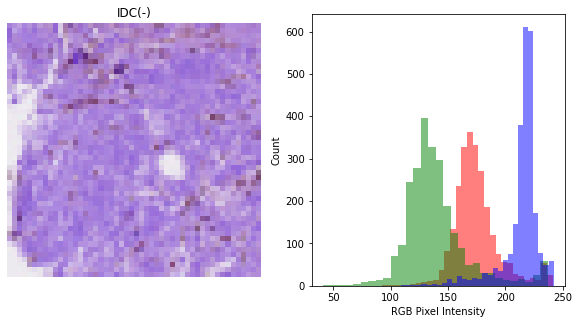

In [ ]:
def plot_histogram(img,index):
    """
    Plot histogram of RGB Pixel Intensities
    """
    # to plot the histogram of the image
    plt.figure(figsize=(10,5))
    # to plot the image
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('IDC(+)' if Y[index] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('RGB Pixel Intensity')
    n_bins = 30
    plt.hist(img[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(img[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(img[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);


index = np.random.randint(temp_df["Images"].shape[0])
plot_histogram(temp_df["Images"].iloc[index], index)
plt.show()

In [ ]:
#print(X[2])

# Normalization
X = np.array(X)
X = X/255
#print(X[2])

X_train, X_temp_dev, Y_train, Y_temp_dev = train_test_split(X, temp_df["Labels"], test_size=0.25)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp_dev, Y_temp_dev, test_size=0.40)

#print(type(X_train))
#print(X_train[0].shape)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


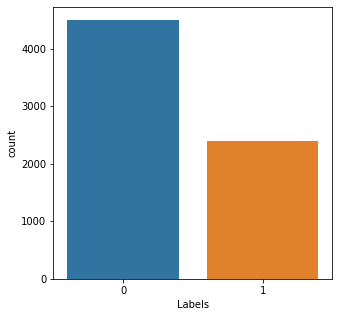

Number of IDC(+) images : 23347
Number of IDC(-) images : 45489
Percentage of IDC(+) images in the dataset : 33.92%
Percentage of IDC(-) images in the dataset : 66.08%


In [ ]:
# Plot the distribution of data
plt.figure(figsize=(5,5))
sns.countplot(Y_test)
plt.show()

# print relevant data
positive_images = temp_df["Labels"].value_counts()[1]
negative_images = temp_df["Labels"].value_counts()[0]
print("Number of IDC(+) images :", positive_images)
print("Number of IDC(-) images :", negative_images)
print("Percentage of IDC(+) images in the dataset :", str(round((100*positive_images)/len(temp_df["Labels"]), 2)) + '%')
print("Percentage of IDC(-) images in the dataset :", str(round((100*negative_images)/len(temp_df["Labels"]), 2)) + '%')

In [ ]:
X_train_shape = X_train[0].shape[0] * X_train[0].shape[1] * X_train[0].shape[2]
X_dev_shape = X_dev[0].shape[0] * X_dev[0].shape[1] * X_dev[0].shape[2]
X_test_shape =  X_test[0].shape[0] * X_test[0].shape[1] * X_test[0].shape[2]

X_train_flatten, X_dev_flatten, X_test_flatten = [], [], []

for i in range(X_train.shape[0]):  
    X_train_flatten.append(X_train[i].flatten().reshape(X_train_shape))
    if i < X_dev.shape[0]:
        X_dev_flatten.append(X_dev[i].flatten().reshape(X_dev_shape))
    if i < X_test.shape[0]:
        X_test_flatten.append(X_test[i].flatten().reshape(X_test_shape))

X_train_flatten = np.array(X_train_flatten)
X_dev_flatten = np.array(X_dev_flatten)
X_test_flatten = np.array(X_test_flatten)

#X_train.shape
print("X_train_flatten dimensions :", X_train_flatten.shape)
print("X_dev_flatten dimensions   :", X_dev_flatten.shape)
print("X_test_flatten dimensions  :", X_test_flatten.shape)
#print(X_test_flatten[0])

X_train_flatten dimensions : (51627, 7500)
X_dev_flatten dimensions   : (10325, 7500)
X_test_flatten dimensions  : (6884, 7500)


100%|██████████| 35132/35132 [00:00<00:00, 577183.18it/s]

X_train_rus Dimensions : (35132, 1, 50, 50, 3)
X_dev_rus Dimensions   : (6790, 1, 50, 50, 3)
X_test_rus Dimensions  : (4772, 1, 50, 50, 3)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 720x720 with 0 Axes>

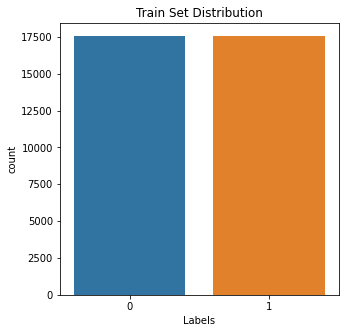

In [ ]:
def random_sample(sample_method):
    sm = sample_method #RandomUnderSampler(ratio='auto', replacement=False)
    X_train_sm, Y_train_sm = sm.fit_resample(X_train_flatten, Y_train)
    X_dev_sm, Y_dev_sm = sm.fit_resample(X_dev_flatten, Y_dev)
    X_test_sm, Y_test_sm = sm.fit_resample(X_test_flatten, Y_test)

    for i in tqdm(range(len(X_train_sm))):
        height, width, channels = 50, 50, 3
        X_train_sm_reshaped = X_train_sm.reshape(len(X_train_sm),1, height, width, channels)
        if i < len(X_dev_sm):
            X_dev_sm_reshaped = X_dev_sm.reshape(len(X_dev_sm), 1,height, width, channels)
        if i < len(X_test_sm):
            X_test_sm_reshaped = X_test_sm.reshape(len(X_test_sm), 1,height, width, channels)

    return X_train_sm_reshaped, Y_train_sm, X_dev_sm_reshaped,\
                Y_dev_sm, X_test_sm_reshaped, Y_test_sm
    

def make_hot_vector(Y_train, Y_dev, Y_test):
    """
      Encode the 'Labels' into the hot vector
    """
    Y_train_hot = to_categorical(Y_train, num_classes = 2)
    Y_dev_hot = to_categorical(Y_dev, num_classes = 2)
    Y_test_hot = to_categorical(Y_test, num_classes = 2)
    return Y_train_hot, Y_dev_hot, Y_test_hot


X_train_rus, Y_train_rus, X_dev_rus,\
Y_dev_rus, X_test_rus, Y_test_rus = random_sample(RandomUnderSampler(sampling_strategy=1))
 
    
Y_train_rus_hot, Y_dev_rus_hot, Y_test_rus_hot =\
       make_hot_vector(Y_train_rus, Y_dev_rus, Y_test_rus)

#plot_imgs(X_train_sm_reshaped)
print("X_train_rus Dimensions :", X_train_rus.shape)
print("X_dev_rus Dimensions   :", X_dev_rus.shape)
print("X_test_rus Dimensions  :", X_test_rus.shape)
plt.clf()
plt.figure(figsize=(5,5))
plt.title('Train Set Distribution')
sns.countplot(Y_train_rus)
plt.show()

In [ ]:
def plot_confusion_matrix(X_data, Y_data_hot, title):
    
    Y_pred_one_hot = model.predict(X_data)
    Y_pred_labels = np.argmax(Y_pred_one_hot, axis=1)
    Y_true_labels = np.argmax(Y_data_hot, axis=1)
    confusion_matrix = metrics.confusion_matrix(y_true=Y_true_labels, y_pred=Y_pred_labels)
       
    cm_df = pd.DataFrame(confusion_matrix, index=["IDC(-)", "IDC(+)"],\
                                         columns=["IDC(-)", "IDC(+)"])
    cm_plot = plt.figure(figsize=(5, 5))
    heatmap = sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Greens") # Yippee, Green!!!
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=12)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm_plot



def plot_learning_curve(training):
    plt.clf()
    plt.figure(figsize=(10, 10))
    
    # plot the entire model history for the accuracy
    plt.subplot(1,2,1)
    plt.plot(training.history['acc'])
    plt.plot(training.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('accuracy_curve.png')

    # plot the entire model history for the losses
    plt.subplot(1,2,2)
    plt.plot(training.history['loss'])
    plt.plot(training.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('loss_curve.png')
    plt.show()

In [ ]:
seq = int(len(X_train)/128) 
model = Sequential()
 
    # Define the Model Architecture.
    ########################################################################################################################
    
model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (1,50,50,3)))
    
model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.5)))

model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.5)))
   
model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.5)))
    
model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.5)))
     
model.add(Flatten()) 
    
model.add(Dense(2, activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 48, 48, 4)      1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 24, 24, 4)     0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 1, 24, 24, 4)     0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 22, 22, 8)      3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 11, 11, 8)     0         
 3D)                                                             
                                                        

In [ ]:
optimizer = 'adam' 

In [ ]:
# compiling the sequential model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer= optimizer)
# training the model for 10 epochs
# model.fit(X_train_rus, Y_train_rus_hot, batch_size=128, epochs=30, validation_data=(X_dev_rus, Y_dev_rus_hot))

Epoch 1/30
275/275 [==============================] - 42s 64ms/step - loss: 0.5518 - accuracy: 0.7269 - val_loss: 0.5070 - val_accuracy: 0.7657
Epoch 2/30
275/275 [==============================] - 17s 62ms/step - loss: 0.4985 - accuracy: 0.7752 - val_loss: 0.5103 - val_accuracy: 0.7694
Epoch 3/30
275/275 [==============================] - 16s 59ms/step - loss: 0.4805 - accuracy: 0.7862 - val_loss: 0.7179 - val_accuracy: 0.6703
Epoch 4/30
275/275 [==============================] - 16s 59ms/step - loss: 0.4793 - accuracy: 0.7852 - val_loss: 0.4994 - val_accuracy: 0.7882
Epoch 5/30
275/275 [==============================] - 16s 60ms/step - loss: 0.4688 - accuracy: 0.7929 - val_loss: 0.4927 - val_accuracy: 0.7816
Epoch 6/30
275/275 [==============================] - 16s 59ms/step - loss: 0.4746 - accuracy: 0.7874 - val_loss: 0.4909 - val_accuracy: 0.7943
Epoch 7/30
275/275 [==============================] - 16s 59ms/step - loss: 0.4600 - accuracy: 0.7985 - val_loss: 0.4995 - val_accuracy:

In [ ]:
# Test set score
score = model.evaluate(X_test_rus, Y_test_rus_hot, verbose=1)
print("Test set loss     : ", score[0])
print("Test set accuracy : ", score[1])
#model.get_weights()

150/150 [==============================] - 1s 8ms/step - loss: 0.5509 - accuracy: 0.7810
Test set loss     :  0.5508612394332886
Test set accuracy :  0.7810142636299133


In [ ]:

#model = load_model('best-mdl_cp_23.h5')

def scores(X_data, Y_data_hot):
    Y_pred_one_hot = model.predict(X_data)
    Y_pred_labels = np.argmax(Y_pred_one_hot, axis=1)
    Y_true_labels = np.argmax(Y_data_hot, axis=1)

    true_positives = np.sum(np.round(np.clip(Y_true_labels * Y_pred_labels, 0, 1)))
    predicted_positives = np.sum(np.round(np.clip(Y_pred_labels, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(Y_true_labels, 0, 1)))

    epsilon = 1e-07
    precision = true_positives / (predicted_positives + epsilon)
    recall = true_positives / (possible_positives + epsilon)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score



# assign all the metrics to 'data' variable
data = [scores(X_train_rus, Y_train_rus_hot), scores(X_dev_rus, Y_dev_rus_hot), \
        scores(X_test_rus, Y_test_rus_hot)]

# Create the pandas DataFrame 
all_metrics = pd.DataFrame(data, columns = ['Precision', 'Recall', 'F1_score'],index = ['Train', 'Validation', 'Test' ]) 



all_metrics

,Precision,Recall,F1_score
Train,0.717396,0.928498,0.809409
Validation,0.719790,0.929897,0.811464
Test,0.718049,0.925398,0.808643


In [ ]:
def plot_confusion_matrix(X_data, Y_data_hot, title):
    
    Y_pred_one_hot = model.predict(X_data)
    Y_pred_labels = np.argmax(Y_pred_one_hot, axis=1)
    Y_true_labels = np.argmax(Y_data_hot, axis=1)
    confusion_matrix = matt(y_true=Y_true_labels, y_pred=Y_pred_labels)
       
    cm_df = pd.DataFrame(confusion_matrix, index=["IDC(-)", "IDC(+)"],\
                                         columns=["IDC(-)", "IDC(+)"])
    cm_plot = plt.figure(figsize=(5, 5))
    heatmap = sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Greens") # Yippee, Green!!!
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=12)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm_plot



def plot_learning_curve(training):
    plt.clf()
    plt.figure(figsize=(10, 10))
    
    # plot the entire model history for the accuracy
    plt.subplot(1,2,1)
    plt.plot(training.history['acc'])
    plt.plot(training.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('accuracy_curve.png')

    # plot the entire model history for the losses
    plt.subplot(1,2,2)
    plt.plot(training.history['loss'])
    plt.plot(training.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('loss_curve.png')
    plt.show()

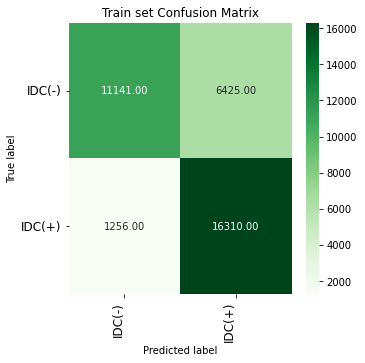

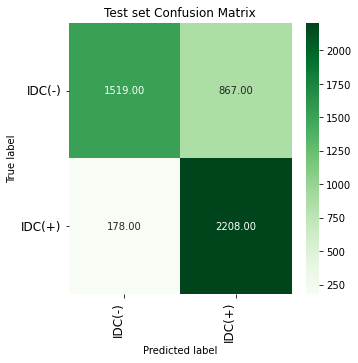

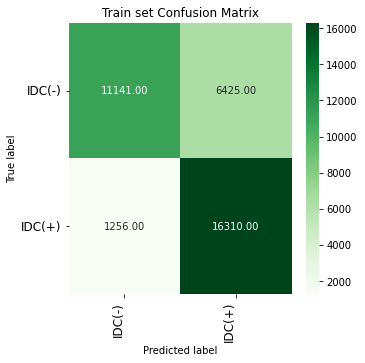

In [ ]:
# Test set confusion matrix
plot_confusion_matrix(X_test_rus, Y_test_rus_hot, title="Test set Confusion Matrix")
plot_confusion_matrix(X_train_rus, Y_train_rus_hot, title="Train set Confusion Matrix")